In [2]:
import cv2
import numpy as np
from scipy import ndimage
#from skimage import measure, color, io
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

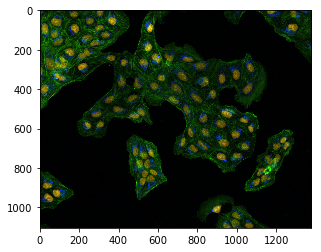

In [4]:
img = cv2.imread("OneDrive/Desktop/OnlineClass/DIP/Mask/Osteosarcoma_01.tif")
plt.imshow(img)

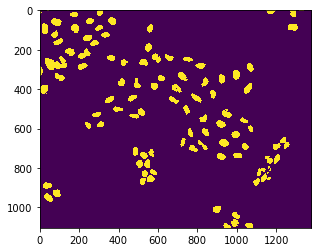

In [5]:
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.
pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh)

In [6]:
# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)


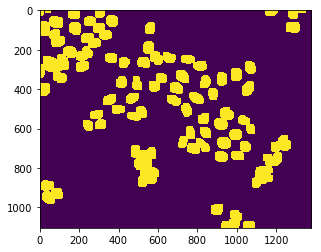

In [7]:
sure_bg = cv2.dilate(opening,kernel,iterations=10)
plt.imshow(sure_bg)

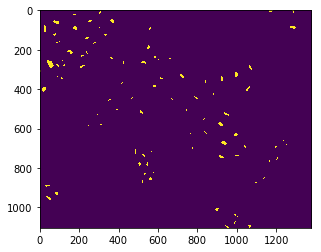

In [8]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

#Let us threshold the dist transform by starting at 1/2 its max value.
#print(dist_transform.max()) gives about 21.9
ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
plt.imshow(sure_fg)

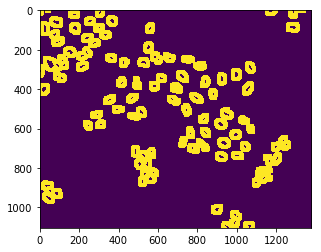

In [9]:
#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
ret3, markers = cv2.connectedComponents(sure_fg)
plt.imshow(unknown)

In [ ]:
#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)
#The boundary region will be marked -1
#https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

#Let us color boundaries in yellow. 
img[markers == -1] = [0,255,255]  
#img2 = color.label2rgb(markers, bg_label=0)

#plt.imshow(img)
cv2.imshow('Overlay on original image', img)
#cv2.imshow('Colored cells', img2)
cv2.waitKey(0)

cv2.destroyAllWindows()